Attempt to create a self consistent solution to the F-layer question!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.optimize as spo
import boundary_layer
import feo_thermodynamics as feot

Pr =  0.09075  Sc =  999.9999999999999


In [2]:
# We will use PREM for pressure, gravity etc.
import sys
sys.path.append('/Users/andrewwalker/Code/prem4derg')
import earth_model
prem = earth_model.Prem()

In [3]:
def setup_flayer_functions(r_icb, r_cmb, r_flayer_top, gamma, delta_t_icb, xfe_adiabatic, xfe_icb):
    """
    This defines the radial functions we are going to need to model the f-layer
    
    Our input parameters are the (total) oxygen content at the top and bottom of 
    the layer, the subadiabatic cooling through the layer, a value for gamma
    for the adiabatic mantle and a thickness of the layer. We first uuse this 
    to find the liquidus temperature at the top of the F-layer. We then requier
    the CMB temperature to generate an adiabat that intersects the liquidus at the
    top of the f-layer.
    
    Arguments are:
    
    r_icb: ICB radius in m
    r_cmb: core mantle boundary radius in m
    r_flayer_top: radius of the top of the f-layer in m
    gamma: grunisen parameter for adiabatic mantle, dimensionless (1.5 is a typical value)
    delta_t_icb: subadiabatic temperature depression at the ICB in K, 10 K is a sensible value
    xfe_adiabatic: oxygen content (as mol frac Fe) of the adiabatic mantle (and top of the F-layer)
                    8-17 mol % O (i.e. 0.92-0.83) are sensible values
    xfe_icb: oxygen content (as mol frac Fe) at the bottom of the F-layer. NB: this is the total oxygen 
             content. As O partititons into the liquid the liquid will be enriched. 
    
    We end up returning a functions that can give the total oxygen content as a function
    of radius, the temperature as a function of radius, and the pressure (from PREM) as
    a function of radius. In the F-layer we assume linear temperature and composition
    profiles. These functions are (numpy) vectorized and take the radii in m. 
    """
    # First find the liquidus temperature at the top of the F-layer... we know P (from PREM)
    # and X (from our input). NB: my PREM module works in km and does not like vector input.
    # This is quite slow and could be optimised by avoiding the double brentq calls!
    tl_top_flayer = feot.find_liquidus(xfe_adiabatic, prem.pressure(radius_top_flayer/1000.0))
    print("Liquidus temperature at top of F-layer is", tl_top_flayer, "K")
    
    # Now we need to work out the adiabatic temperature profile that intersects the liquidus 
    # at the top of the F-layer. 
    rho_cmb = prem.density((radius_cmb-0.1)/1000.0) # -0.1 for core, not mantle rho
    rho_top_flayer = prem.density(radius_top_flayer/1000.0)
    def _t_error_top_flayer(tcmb):
        """
        For a given CMB temperature, calculate the difference between the temperature
        at the top of the f-layer and the liquidus temperature. We'll need to set 
        tcmb such that this is zero!
        """
        adabat_t_top_flayer = tcmb * (rho_top_flayer/rho_cmb)**gamma
        t_error = adabat_t_top_flayer - tl_top_flayer
        return t_error
    t_cmb = spo.brentq(_t_error_top_flayer, 1000, 8000)
    
    print("Temperature CMB is", t_cmb, "K")
    
    # We can now build our function to give the adiabatic temperature
    rho_icb = prem.density(radius_inner_core/1000.0)
    adabat_t_top_flayer = t_cmb * (rho_top_flayer/rho_cmb)**gamma
    adabat_icb = t_cmb * (rho_icb/rho_cmb)**gamma
    @np.vectorize
    def adiabatic_temperature_function(r):
        temp = t_cmb * (prem.density(r/1000.0)/rho_cmb)**gamma
        return temp
    
    # And the function to give the 'real' temperature (including a subadiabatic layer)
    # We'll base temperature on an adiabat (temperature at top of F-layer)
    # and then assume it's linear to a subadiabatic ICB temperature
    # Do note that we cannot use the ICB as a tie point as (1) the F-layer
    # is not adiabatic and (2) we are not assuming phase equilibrium at the ICB
    # which means the ICB need not be at any particular melting temperature. 
    # This is an important point (probably the most important point if we introduce
    # non-equilibrium processes).
    temperature_icb = adabat_icb - delta_t_icb
    @np.vectorize
    def temperature_function(r):
        if r > radius_top_flayer:
            temp = t_cmb * (prem.density(r/1000.0)/rho_cmb)**gamma
        elif r >= radius_inner_core:
            temp = temperature_icb + (r - r_icb)*(
                (adabat_t_top_flayer-temperature_icb)/(r_flayer_top-r_icb))
        else:
            raise NotImplementedError("What's going on")
        return temp
    

    # Finally, a function to give the composition everywhere
    @np.vectorize
    def composition_function(r):
        if r > radius_top_flayer:
            xfe = xfe_adiabatic
        elif r >= radius_inner_core:
            xfe = xfe_icb + (r - r_icb)*(
                (xfe_adiabatic-xfe_icb)/(r_flayer_top-r_icb))
        else:
            raise NotImplementedError("What's going on")
        return xfe
                
    pressure_function = np.vectorize(prem.pressure)
    
    return temperature_function, adiabatic_temperature_function, composition_function, pressure_function






In [4]:
# F-layer setup
radius_inner_core = 1221.5e3
radius_top_flayer = radius_inner_core + 200.0e3
radius_cmb = 3480.0e3
gamma = 1.5

# IVP defaults
start_time = 0 # s
max_time = 1000000 # s
rtot = 1.0 # initial box radius

# Physical properties
initial_particle_size = 1.0E-10 # initial radius, m - should be critical radius for nucleation
k0 = 150.0 # growth rate prefactor, m/s
dl = 1.0E-9 # diffusion
mu = 1.0e-6 # kinematic viscosity

tfunc, atfunc, xfunc, pfunc = setup_flayer_functions(radius_inner_core, radius_cmb, radius_top_flayer, 
                                                    gamma, 10.0, 0.92, 0.92)

Liquidus temperature at top of F-layer is 5698.941318305444 K
Temperature CMB is 4242.543317870397 K


In [5]:
print("Pressure at ICB:", prem.pressure(radius_inner_core/1000.0), "GPa")
print("Pressure at top of F-layer", prem.pressure(radius_top_flayer/1000.0), "GPa")
print("g at ICB:", prem.gravity(radius_inner_core/1000.0), "m/s**2")
print("g at top of F-layer", prem.gravity(radius_top_flayer/1000.0), "m/s**2")

Pressure at ICB: 329.1010089948369 GPa
Pressure at top of F-layer 317.7026904318656 GPa
g at ICB: 4.403124222842614 m/s**2
g at top of F-layer 5.010242771751181 m/s**2


In [6]:
rs = np.linspace(radius_inner_core, radius_inner_core+500.0E3)
ts = tfunc(rs)
ats = atfunc(rs)
ps = pfunc(rs/1000.0)
xs = xfunc(rs)
tl = feot.find_liquidus(xs, ps)

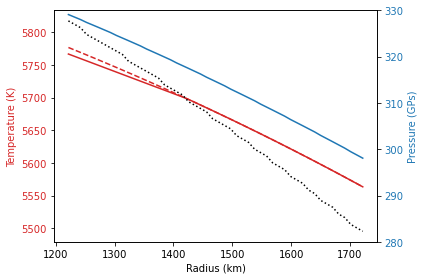

In [7]:


fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Radius (km)')
ax1.set_ylabel('Temperature (K)', color=color)
ax1.plot(rs/1000.0, ts, color=color)
ax1.plot(rs/1000.0, ats, color=color, ls='--')
ax1.plot(rs/1000.0, tl, color='k', ls=':')

ax1.tick_params(axis='y', labelcolor=color)
#ax1.set_ylim([5900, 6200])

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Pressure (GPs)', color=color)  
ax2.plot(rs/1000.0, ps, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([280, 330])

fig.tight_layout()  
plt.show()


## Equilibrium calculation

(This is really easy...)

In [8]:
feot.volume_fraction_solid(xs, ps, ts)

array([0.08457566, 0.08209002, 0.07958301, 0.06902238, 0.06641458,
       0.06378388, 0.06112998, 0.05845259, 0.05575122, 0.05302592,
       0.04166147, 0.03882261, 0.03595786, 0.03306674, 0.03014913,
       0.02720455, 0.01503412, 0.01196271, 0.00886222, 0.00573231,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [9]:
x_lq, phi_fe, phi_lq, phi_feo, phi_solid = feot.phase_relations_molar(xs, ps, ts)
x_lq

array([0.91212214, 0.91237419, 0.91262704, 0.9136778 , 0.91393351,
       0.91419003, 0.91444738, 0.91470554, 0.91496453, 0.91522434,
       0.91629226, 0.91655502, 0.91681863, 0.91708308, 0.91734839,
       0.91761454, 0.91869797, 0.91896716, 0.91923722, 0.91950816,
       0.92      , 0.92      , 0.92      , 0.92      , 0.92      ,
       0.92      , 0.92      , 0.92      , 0.92      , 0.92      ,
       0.92      , 0.92      , 0.92      , 0.92      , 0.92      ,
       0.92      , 0.92      , 0.92      , 0.92      , 0.92      ,
       0.92      , 0.92      , 0.92      , 0.92      , 0.92      ,
       0.92      , 0.92      , 0.92      , 0.92      , 0.92      ])

In [10]:
liquid_density, solid_mixture_density, fe_liquid_density, fe_hpc_density, \
           feo_liquid_density, feo_solid_density = feot.densities(xs, ps, ts)

## Non-equilibrium calculation